# Asymptotic Formula Conversion to Python Test

In [103]:
import equadratures as eq
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import time

from scipy.special import jn_zeros


In [104]:
def legpts_nodes(a, u, a2, u2, n, vn):
    """Compute nodes using asymptotic formulae."""

    F0 = a
    F1 = 1/8 * (u * a - 1) / a

    if n < 1e4:
        a3 = a ** 3
        F2 = 1/384 * (6 * a2 * (1 + u2) + 25 - u * (31 * u2 + 33) * a3) / a3
    else:
        F2 = 0

    if n < 1e3:
        u4 = u ** 4
        a5 = a ** 5
        R30 = u * (2595 + 6350 * u2 + 3779 * u4) / 15360
        R31 = -(31 * u2 + 11) / 1024
        R32 = u / 512
        R33 = -25 / 3072
        R35 = -1073 / 5120
        F3 = R30 + R35 / a5 + (1 + u2) * (R31 / a + R32 / a2 + R33 / a3)
    else:
        F3 = 0

    t = F0 + F1 * vn ** 2 + F2 * vn ** 4 + F3 * vn ** 6
    x = np.cos(t)

    return x, t

In [105]:
def legpts_weights(ua, a, a2, u, u2, n, vn, m):
    """Compute weights using asymptotic formulae."""

    W0 = 1
    W1 = 1/8 * (ua + a2 - 1) / a**2

    if n < 1e4:
        a3 = a**3
        a4 = a2**2
        u4 = u**4
        W2 = 1/384 * (81 - 31*ua - 3*(1 - 2*u2)*a2 + 6*u*a3 - (27 + 84*u2 + 56*u4)*a4) / a4
    else:
        W2 = 0

    if n < 1e3:
        u3 = u**3
        u5 = u**5
        u6 = u3**2
        a5 = a**5
        a6 = a3**2
        Q30 = 187/96*u4 + 295/256*u2 + 151/160*u6 + 153/1024
        Q31 = -119/768*u3 -35/384*u5 - 65/1024*u
        Q32 = 5/512 + 7/384*u4 + 15/512*u2
        Q33 = u3/512 - 13/1536*u
        Q34 = -7/384*u2 + 53/3072
        Q35 = 3749/15360*u
        Q36 = -1125/1024
        W3 = Q30 + Q31/a + Q32/a2 + Q33/a3 + Q34/a4 + Q35/a5 + Q36/a6
    else:
        W3 = 0

    Jk2 = bessel12atj0k(m)

    w = 2 / ((np.array(Jk2)/vn**2) * (a/np.sin(a)) * (W0 + W1*vn**2 + W2*vn**4 + W3*vn**6))

    return w

In [106]:
def bessel12atj0k(m):
    """Evaluate besselj(1,x).^2 at roots of besselj(0,x)."""
    m = int(m)
    Jk2 = np.zeros(m)

    Jk3 = [0.2695141239419169, 
           0.1157801385822037, 
           0.07368635113640822, 
           0.05403757319811628, 
           0.04266142901724309, 
           0.03524210349099610, 
           0.03002107010305467, 
           0.02614739149530809, 
           0.02315912182469139, 
           0.02078382912226786]

    if m <= 10:
        return Jk3[:m]
    else:
        Jk2[:10] = Jk3

    k = np.arange(11, m + 1)
    ak = np.pi * (k - 0.25)
    ak2inv = (1.0 / ak) ** 2
    c = [-171497088497/15206400, 461797/1152, -172913/8064, 151/80, -7/24, 0, 2]

    Jk2[k - 1] = 1.0 / (np.pi * ak) * (c[6] + ak2inv**2 * (c[4] + ak2inv * (c[3] + 
        ak2inv * (c[2] + ak2inv * (c[1] + ak2inv * c[0])))))

    return Jk2

In [107]:
def asy1(n, nout):
    """Compute nodes and weights using asymptotic formulae."""

    # Compute roots of BesselJ(0, x)
    m = np.ceil(n / 2)
    jk = jn_zeros(0, int(m))

    # Useful values
    vn = 1. / (n + 0.5)
    a = jk * vn
    u = 1. / np.tan(a)
    ua = u * a
    u2 = u ** 2
    a2 = a ** 2

    # Initialise for storage (so as to only compute once)
    Jk2 = []
    u3, a3 = [], []
    u4, a4 = [], []
    u5, a5 = [], []
    u6, a6 = [], []

    # Compute nodes and weights
    x, t = legpts_nodes(a, u, a2, u2, n, vn)
    w = legpts_weights(ua, a, a2, u, u2, n, vn, m) if nout > 1 else []
    v = np.sin(t) / np.sqrt(2. / w) / v[-1] if nout > 2 else []

    # Use symmetry
    if n % 2 == 0:
        x = np.concatenate([-x, x[::-1]])
        w = np.concatenate([w, w[::-1]]).T
        v = np.concatenate([v, v[::-1]])
        t = np.concatenate([np.pi - t, t[::-1]])
    else:
        x = np.concatenate([-x[:-1], [0], x[:-2:-1]])
        w = np.concatenate([w[:], w[:-2:-1]]).T
        v = np.concatenate([v[:-1], v[:-2:-1]])
        t = np.concatenate([np.pi - t, t[:-2:-1]])

    return x, w, v, t

In [108]:
def asy(n, nout, a=-1, b=1):
    """Compute nodes and weights using asymptotic formulae for a specified interval [a, b]."""

    # Compute roots of BesselJ(0, x)
    m = np.ceil(n / 2)
    jk = jn_zeros(0, int(m))

    # Useful values
    vn = 1. / (n + 0.5)
    c = (b - a) / 2
    d = (b + a) / 2
    x = jk * vn
    t = d + c * x

    # Compute nodes and weights in [-1, 1]
    x, w, v, t = asy1(n, nout)

    # Map nodes and weights to [a, b]
    x = d + c * x
    w = c * w
    v = v / np.sqrt(2 * w[-1])
    x = x.reshape(n,1);
    return x, w, v, t


In [109]:
points1, weights1, v, t = asy(10, 2, a=-2, b=2)

Testing with
$$
F(x) = \int_{-1}^{1}f(x)dx=\int_{-1}^{1}xsin(x^2)dx \\
F(x) = \Bigg[-\frac{cos(x^2)}{2}\Bigg]_{-1}^{\;\,1} = 0 
$$
True value of $F=0$

and

$$
G(x) = \int_{-1}^{1}f(x)dx=\int_{-1}^{1}e^xdx \\
G(x) = \big[e^x\big]_{-1}^{\;\,1} = 2.3504023872876029137647637
$$
True value of $F=0$

In [110]:
def f(x):
    return x*np.sin(x**2);
def g(x):
    return np.exp(x);

TRUE_G = 2.3504023872876029137647637


NUM_STEPS = 100
STEP = 1000
xValues = np.linspace(STEP,NUM_STEPS*STEP,NUM_STEPS);

# def errorF(y):
#     return y;
# Error is just equal to value, so unnecessary


In [120]:
fValues = np.zeros(NUM_STEPS);

p_bar = tqdm(range(NUM_STEPS))
for o1 in p_bar:
    p_bar.set_description(f'n = {o1*STEP}')
    points, weights, v, t = asy((o1+1)*STEP, 2);
    fValues[o1] = float(np.dot(weights, eq.evaluate_model(points, f)));


  0%|          | 0/100 [00:00<?, ?it/s]

$$
Error_{F(x)} = F(x) -\sum_{i=1}^{n}f(points_i)*weights_i \\
$$

### Integration Error

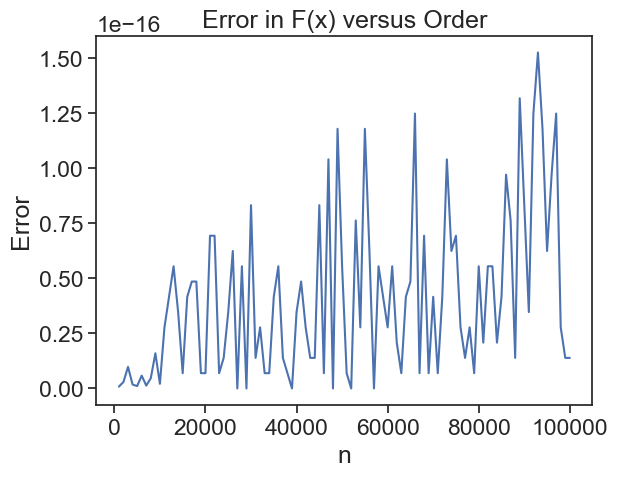

In [121]:
fValues = np.absolute(fValues)
plt.plot(xValues, fValues)
plt.xlabel('n')
plt.ylabel('Error')
plt.title("Error in F(x) versus Order")
plt.show();

### Difference between Equadratures Weights and Asymptotic Implementation

In [113]:
points100Asy, weights100Asy, v100, t100 = asy(100, 2);
points500Asy, weights500Asy, v500, t500 = asy(500,2);
points1000Asy, weights1000Asy, v1000, t1000 = asy(1000,2);
print(weights100Asy.sum())

basis = eq.Basis('univariate');
param1 = eq.Parameter(lower=-1, upper=1, order=99, distribution='uniform');
param2 = eq.Parameter(lower=-1, upper=1, order=499, distribution='uniform');
param3 = eq.Parameter(lower=-1, upper=1, order=999, distribution='uniform');
poly1 = eq.Poly(param1, basis, method='numerical-integration')
poly2 = eq.Poly(param2, basis, method='numerical-integration')
poly3 = eq.Poly(param3, basis, method='numerical-integration')

points100Eq, weights100Eq = poly1.get_points_and_weights();
points500Eq, weights500Eq = poly2.get_points_and_weights();
points1000Eq, weights1000Eq = poly3.get_points_and_weights();

1.9999999999999998


In [114]:
diff1 = np.absolute((weights100Asy/2)-weights100Eq);
diff2 = np.absolute((weights500Asy/2)-weights500Eq);
diff3 = np.absolute((weights1000Asy/2)-weights1000Eq);

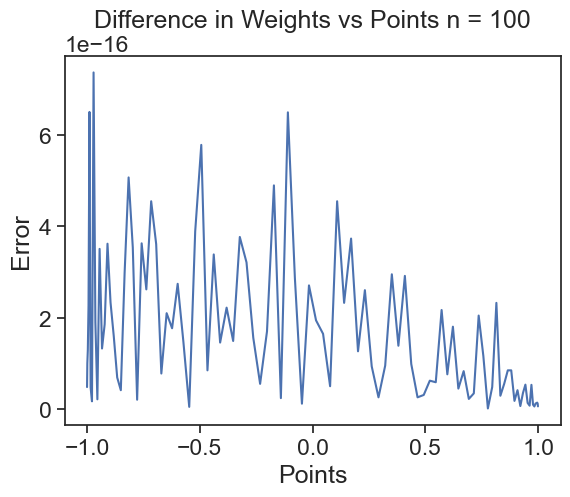

In [115]:
plt.plot(points100Asy, diff1)
# plt.plot(points100Eq, weights100Eq, label='Equadratures')
plt.xlabel('Points');
plt.ylabel('Error');
plt.title('Difference in Weights vs Points n = 100')
# plt.legend()
plt.show()

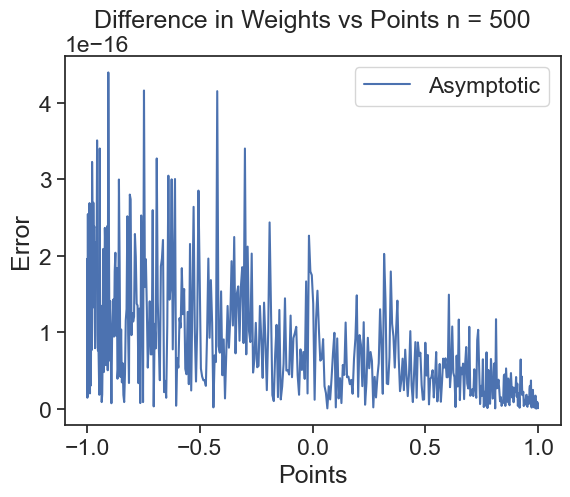

In [116]:
plt.plot(points500Asy, diff2, label='Asymptotic')
# plt.plot(points500Eq, weights500Eq, label='Equadratures')
plt.xlabel('Points');
plt.ylabel('Error');
plt.title('Difference in Weights vs Points n = 500')
plt.legend()
plt.show()

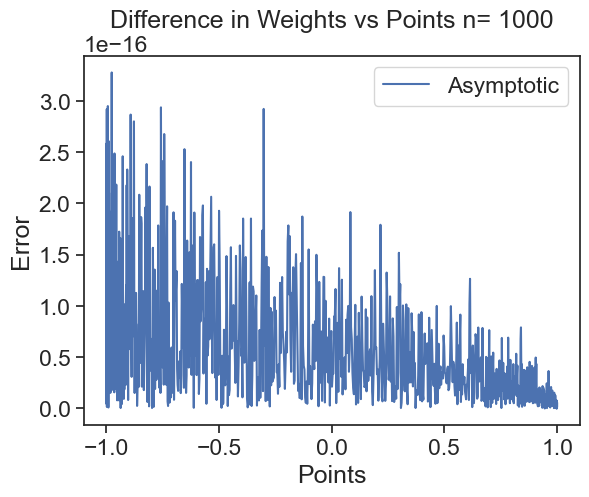

In [117]:
plt.plot(points1000Asy, diff3, label='Asymptotic')
# plt.plot(points1000Eq, weights1000Eq, label='Equadratures')
plt.xlabel('Points');
plt.ylabel('Error');
plt.title('Difference in Weights vs Points n= 1000')
plt.legend()
plt.show()

### Difference in Points between Equadratures and Asymptotic Implementation

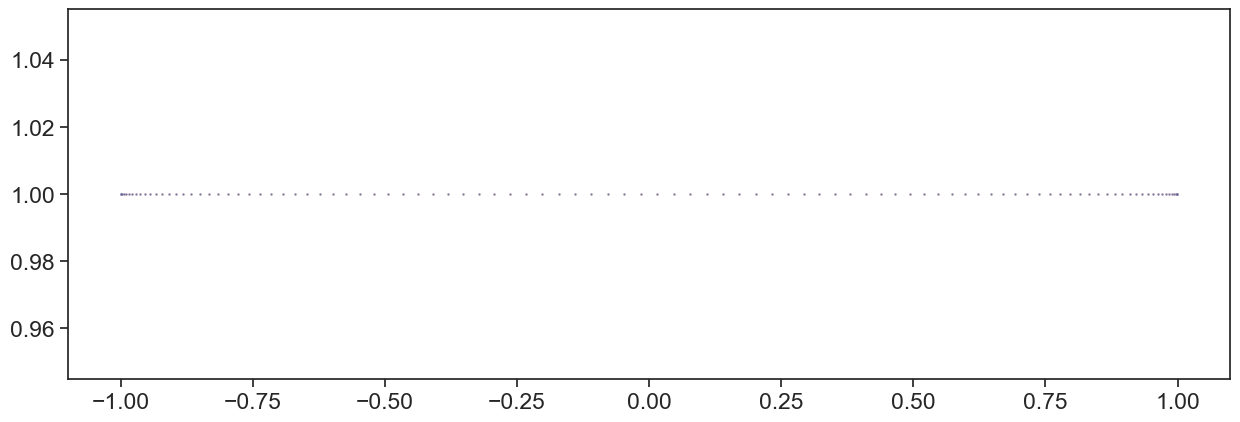

In [142]:
y1 = np.ones(100)
plt.figure().set_figwidth(15)
plt.scatter(points100Asy, y1, s= 0.5, alpha=0.5,color='r')
plt.scatter(points100Eq, y1, s= 0.5, alpha=0.5,color='b')
plt.show()

Not very useful as it stands, but it looks like you can see some differences towards the edges.

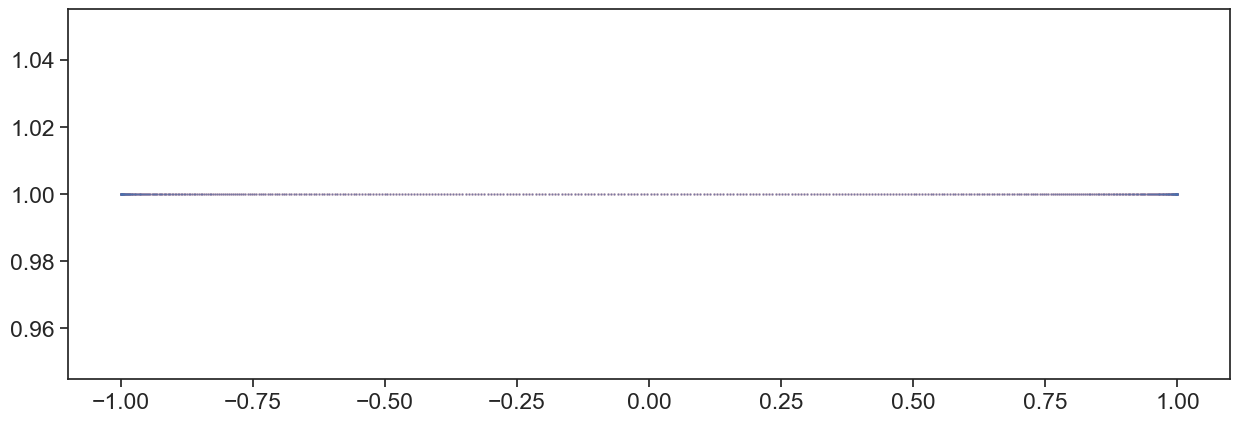

In [143]:
y2 = np.ones(500)
plt.figure().set_figwidth(15)
plt.scatter(points500Asy, y2, s= 0.5, alpha=0.5,color='r')
plt.scatter(points500Eq, y2, s= 0.5, alpha=0.5,color='b')
plt.show()

Little more different but it gets too clumped, lets see if we can zoom in on n=1000

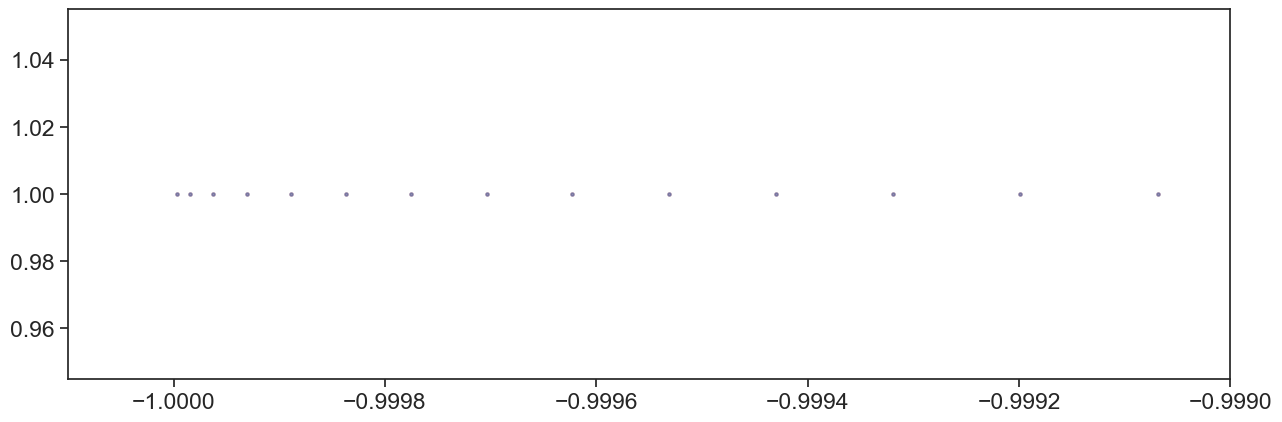

In [152]:
y3 = np.ones(1000)
plt.figure().set_figwidth(15)
plt.scatter(points1000Asy, y3, s= 5, alpha=0.5,color='r')
plt.scatter(points1000Eq, y3, s= 5, alpha=0.5,color='b')
plt.xlim(-1.0001,-0.999)
plt.show()

Not that useful still.